# Proyek Recommendation System: Movie Lens Small Latest Dataset
- **Nama:** Meilani Kizana
- **Email:** meilanikizana@gmail.com
- **ID Dicoding:** Meilani Kizana

## Import Library

Tahapan ini merupakan tahap untuk melakukan import semua library yang akan digunakan selama proyek.

In [1]:
import os
import numpy as np
import pandas as pd
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Data Loading

Tahapan ini merupakan tahap untuk mengunggah dataset dari Kaggle dan menyimpannya ke dataframe.

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meilanikizana","key":"230db92153864ff31f16103462e6c659"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d shubhammehta21/movie-lens-small-latest-dataset
!unzip movie-lens-small-latest-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset
License(s): unknown
  0% 0.00/971k [00:00<?, ?B/s]
100% 971k/971k [00:00<00:00, 1.29GB/s]
Archive:  movie-lens-small-latest-dataset.zip
  inflating: README.txt              
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: tags.csv                


Dataset yang diunggah dari kaggle terdiri atas 5 file yaitu:
- README.txt: Berisi tentang informasi terkait dataset
- links.csv: Berisi tentang id film dengan id IMDB dan id TMDB untuk memudahkan koneksi dengan sumber data lain
- movies.csv: Berisi tentang informasi film
- ratings.csv: Berisi tentang informasi rating film oleh pengguna
- tags.csv: Berisi tentang informasi tag film oleh pengguna

In [5]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

print('Jumlah data id film: ', len(links.movieId.unique()))
print('Jumlah data film: ', len(movies.movieId.unique()))
print('Jumlah data rating: ', len(ratings.userId))
print('Jumlah pengguna yang memberikan rating: ', len(ratings.userId.unique()))
print('Jumlah film yang diberikan rating: ', len(ratings.movieId.unique()))
print('Jumlah pengguna yang memberikan tag: ', len(tags.userId.unique()))
print('Jumlah film yang diberikan tag: ', len(tags.movieId.unique()))

Jumlah data id film:  9742
Jumlah data film:  9742
Jumlah data rating:  100836
Jumlah pengguna yang memberikan rating:  610
Jumlah film yang diberikan rating:  9724
Jumlah pengguna yang memberikan tag:  58
Jumlah film yang diberikan tag:  1572


Tahap diatas digunakan untuk menyimpan setiap file ke dalam dataframe masing-masing dan menampilkan beberapa sekilas informasi mengenai jumlah data.

## Univariate Exploratory Data Analysis

Tahapan ini merupakan tahap ekplorasi data untuk dapat memahami setiap data dengan lebih baik.

In [6]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


'links' yang berasal dari file links.csv berisi 3 kolom yaitu movieId, imdbId, dan tmdbId dengan total baris/data yaitu 9742. Data ini berguna sebagai jembatan yang menghubungkan data film dari dataset ini dengan dataset lain. Namun pada proyek ini, saya hanya menggunakan dataset ini dan tidak menggabungkan data dengan dataset lain sehingga data pada 'links' tidak akan digunakan.

In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


'movies' yang berasal dari file movies.csv berisi 3 kolom yaitu movieId, title, dan genres dengan total baris/data yaitu 9742. Data ini merupakan data yang berisikan informasi film seperti id, judul, dan genrenya. Data ini akan digunakan untuk membangun sistem rekomendasi content based filtering.

In [8]:
print('Banyak film: ', len(movies.movieId.unique()))
print('Judul film: ', movies.title.unique())

print('\nBanyak genre: ', len(movies.genres.unique()))
print('Genre film: ', movies.genres.unique())

Banyak film:  9742
Judul film:  ['Toy Story (1995)' 'Jumanji (1995)' 'Grumpier Old Men (1995)' ...
 'Flint (2017)' 'Bungo Stray Dogs: Dead Apple (2018)'
 'Andrew Dice Clay: Dice Rules (1991)']

Banyak genre:  951
Genre film:  ['Adventure|Animation|Children|Comedy|Fantasy'
 'Adventure|Children|Fantasy' 'Comedy|Romance' 'Comedy|Drama|Romance'
 'Comedy' 'Action|Crime|Thriller' 'Adventure|Children' 'Action'
 'Action|Adventure|Thriller' 'Comedy|Horror'
 'Adventure|Animation|Children' 'Drama' 'Action|Adventure|Romance'
 'Crime|Drama' 'Drama|Romance' 'Action|Comedy|Crime|Drama|Thriller'
 'Comedy|Crime|Thriller' 'Crime|Drama|Horror|Mystery|Thriller'
 'Drama|Sci-Fi' 'Children|Drama' 'Adventure|Drama|Fantasy|Mystery|Sci-Fi'
 'Mystery|Sci-Fi|Thriller' 'Children|Comedy' 'Drama|War'
 'Action|Crime|Drama' 'Action|Adventure|Fantasy' 'Comedy|Drama|Thriller'
 'Mystery|Thriller' 'Animation|Children|Drama|Musical|Romance'
 'Crime|Mystery|Thriller' 'Adventure|Drama' 'Drama|Thriller'
 'Comedy|Crime' 'Actio

Jumlah film yang terdapat dalam movies adalah 9708 dan genrenya 950. Genre setiap film terdiri dari kombinasi beberapa genre, bukan hanya satu genre. Sehingga akan diperlukan persiapan sebelum melakukan modelling.

In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


'ratings' yang berasal dari file ratings.csv berisi 4 kolom yaitu userId, movieId, rating, dan timestamp dengan total baris/data yaitu 100836. Data ini merupakan data yang berisikan informasi rating film yang diberikan oleh pengguna. Data ini akan digunakan untuk membangun sistem rekomendasi collaborative filtering.

In [10]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Dari tahap diatas, dapat diketahui rentang rating adalah 0-5, dengan rating paling kecil yang diberikan oleh pengguna adalah 0.5 dan paling besar yaitu 5.

In [11]:
print('Jumlah user yang memberikan rating: ', len(ratings.userId.unique()))
print('Jumlah film yang diberikan rating: ', len(ratings.movieId.unique()))
print('Jumlah data rating: ', len(ratings))

Jumlah user yang memberikan rating:  610
Jumlah film yang diberikan rating:  9724
Jumlah data rating:  100836


Tahapan diatas guna mengetahui jumlah pengguna dan jumlah film yang terdapat pada data 'ratings'. Jumlah pengguna yang memberikan rating adalah 610. Jumlah film yang diberikan rating adalah 9724. Dengan total seluruh data adalah 100836. Artinya 1 pengguna memberikan ratin pada lebih dari 1 film. Serta 1 film memiliki rating dari berbagai pengguna.

In [12]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [13]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


'tags' yang berasal dari file tags.csv berisi 4 kolom yaitu userId, movieId, tag, dan timestamp dengan total baris/data yaitu 3683. Data ini merupakan data yang berisikan informasi tag film yang diberikan oleh pengguna. Namun pada proyek ini, saya hanya menggunakan genre sebagai basis untuk content based filtering, sehingga data ini tidak digunakan.

In [15]:
print("Nilai kosong pada data movies:")
print(movies.isnull().sum())

print("\nNilai kosong pada data ratings:")
print(ratings.isnull().sum())

Nilai kosong pada data movies:
movieId    0
title      0
genres     0
dtype: int64

Nilai kosong pada data ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [16]:
print("Jumlah data duplikat pada movies:", movies.duplicated().sum())
print("Jumlah data duplikat pada ratings:", ratings.duplicated().sum())

Jumlah data duplikat pada movies: 0
Jumlah data duplikat pada ratings: 0


Tahap diatas digunakan untuk mengidentifikasi nilai kosong dan data duplikat pada data movies dan ratings yang akan digunakan pada proyek kali ini. Dari hasil dapat dilihat bahwa tidak terdapat nilai kosong maupun data duplikat pada kedua data tersebut.

### Visualisasi Data

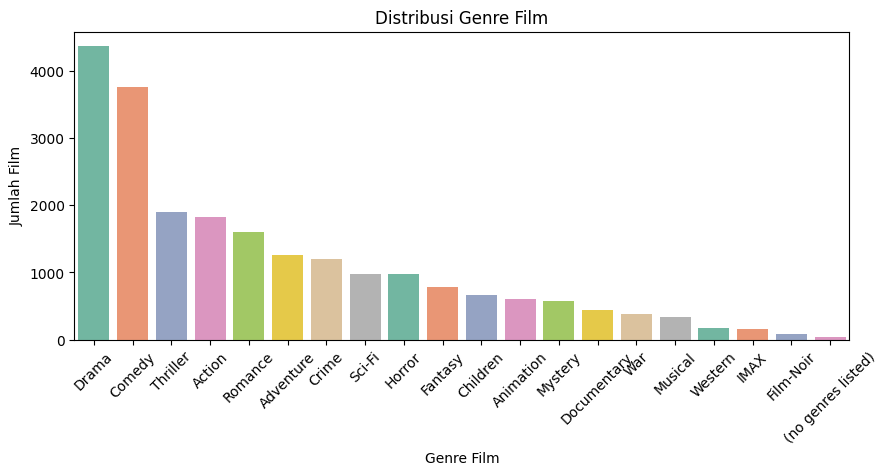

In [17]:
genre_counts = movies['genres'].str.get_dummies(sep='|').sum().sort_values(ascending=False)
genre_df = genre_counts.reset_index()
genre_df.columns = ['Genre', 'Jumlah']

plt.figure(figsize=(10, 4))
sns.barplot(data=genre_df, x='Genre', y='Jumlah', palette='Set2', hue='Genre')

plt.title('Distribusi Genre Film')
plt.xlabel('Genre Film')
plt.ylabel('Jumlah Film')
plt.xticks(rotation=45)
plt.show()

In [18]:
movies[movies['genres'] == '(no genres listed)']

,movieId,title,genres
8517,114335,La cravate (1957),(no genres listed)
8684,122888,Ben-hur (2016),(no genres listed)
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed)
8782,129250,Superfast! (2015),(no genres listed)
8836,132084,Let It Be Me (1995),(no genres listed)
8902,134861,Trevor Noah: African American (2013),(no genres listed)
9033,141131,Guardians (2016),(no genres listed)
9053,141866,Green Room (2015),(no genres listed)
9070,142456,The Brand New Testament (2015),(no genres listed)
9091,143410,Hyena Road,(no genres listed)


Tahap diatas digunakan untuk menampilkan visualisasi dari distribusi genre dalam data. Dari hasilnya dapat diketahui bahwa genre drama dan comedy cukup mendominasi jumlahnya. Selain itu, terdapat (no genres listed) dalam visualiasi diatas. Hal ini menunjukkan terdapat film yang belum diberikan genre. Hal ini akan ditangani pada tahapan persiapan data.

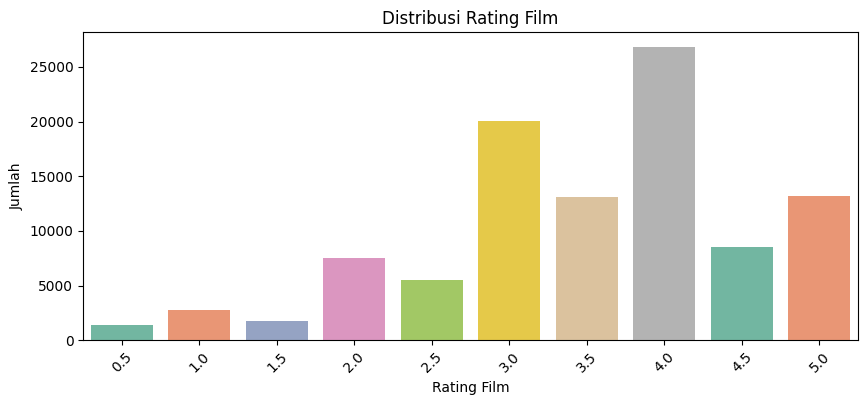

In [19]:
rating_counts = ratings['rating'].value_counts().sort_index()
rating_df = rating_counts.reset_index()
rating_df.columns = ['Rating', 'Jumlah']

plt.figure(figsize=(10, 4))
sns.barplot(data=rating_df, x='Rating', y='Jumlah', palette='Set2', hue='Rating')

plt.title('Distribusi Rating Film')
plt.xlabel('Rating Film')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.legend().set_visible(False)
plt.show()

Tahap diatas digunakan untuk menampilkan visualisasi dari distribusi rating film dalam data. Dari hasilnya dapat diketahui bahwa rating 3.0 dan 4.0 cukup mendominasi jumlahnya. Adapun rating 0.5 dan 1.5 memiliki jumlah yang paling sedikit.

## Data Preparation

Tahapan ini merupakan tahap untuk mempersiapkan data sebelum masuk ke tahap modelling. Proyek ini akan membangun sistem rekomendasi dengan content based filtering dan collaborative filtering, sehingga persiapan data juga dipisahkan berdasarkan dua metode pendekatan tersebut.

### Content Based Filtering Data Preparation

Pendekatan content based filtering yang diterapkan pada proyek ini adalah berdasarkan genre film sehingga data yang digunakan adalah 'movies'. Setelah dilakukan ekplorasi data sebelumnya, dapat diketahui bahwa data 'movies' tidak memiliki nilai kosong dan data duplikat, sehingga tahapan ini berisikan tahap untuk mengatasi nilai genre yang kurang yaitu '(no genres listed)' serta tf-idf vectorizer untuk menemukan representasi fitur penting dari setiap kombinasi genre.

In [20]:
movies = movies[movies['genres'] != '(no genres listed)']

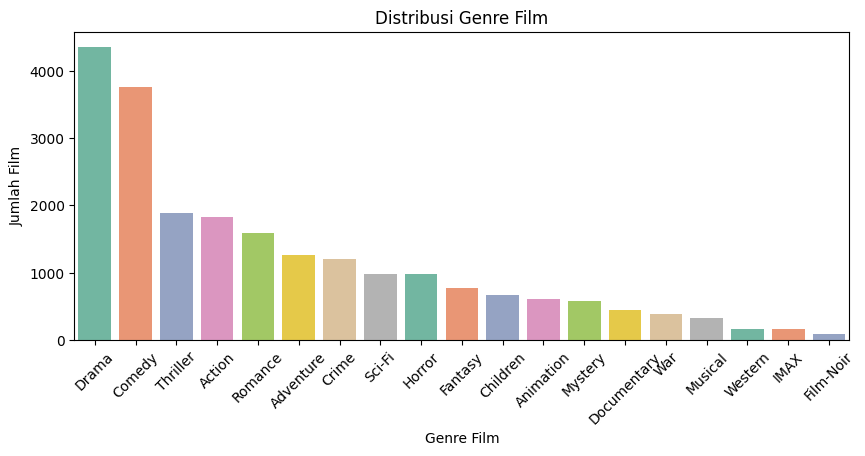

In [21]:
genre_counts = movies['genres'].str.get_dummies(sep='|').sum().sort_values(ascending=False)
genre_df = genre_counts.reset_index()
genre_df.columns = ['Genre', 'Jumlah']

plt.figure(figsize=(10, 4))
sns.barplot(data=genre_df, x='Genre', y='Jumlah', palette='Set2', hue='Genre')

plt.title('Distribusi Genre Film')
plt.xlabel('Genre Film')
plt.ylabel('Jumlah Film')
plt.xticks(rotation=45)
plt.show()

Setelah dihapus, dilakukan pengecekan kembali melalui visualisasi untuk memastikan bahwa setiap data dengan genre yang tidak sesuai sudah berhasil ditangani. Dari hasil visualisasi diatas, dapat dilihat bahwa nilai '(no genres listed)' sudah tidak ada.

In [22]:
tfidf = TfidfVectorizer()

tfidf.fit(movies['genres'])

tfidf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'horror', 'imax',
       'musical', 'mystery', 'noir', 'romance', 'sci', 'thriller', 'war',
       'western'], dtype=object)

In [23]:
tfidf_matrix = tfidf.fit_transform(movies['genres'])

tfidf_matrix.shape

(9708, 21)

In [24]:
tfidf_matrix.todense()

matrix([[0.        , 0.4168036 , 0.51628768, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51229321, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.5784593 , 0.        , 0.81571125, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [25]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=movies.title
).sample(21, axis=1).sample(10, axis=0)

,comedy,film,mystery,sci,noir,thriller,fantasy,war,fi,action,...,crime,musical,documentary,imax,adventure,romance,children,animation,drama,horror
title,,,,,,,,,,,,,,,,,,,,,
"Nightmare on Elm Street, A (1984)",0.000000,0.0,0.000000,0.0,0.0,0.624466,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.781052
...And Justice for All (1979),0.000000,0.0,0.000000,0.0,0.0,0.825596,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.564262,0.000000
Born on the Fourth of July (1989),0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.920237,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.391360,0.000000
In Bruges (2008),0.401877,0.0,0.000000,0.0,0.0,0.542967,0.0,0.000000,0.0,0.000000,...,0.637157,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.371097,0.000000
"Usual Suspects, The (1995)",0.000000,0.0,0.685963,0.0,0.0,0.471951,0.0,0.000000,0.0,0.000000,...,0.553821,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
Another 48 Hrs. (1990),0.352090,0.0,0.000000,0.0,0.0,0.475701,0.0,0.000000,0.0,0.482104,...,0.558222,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.325123,0.000000
Catwalk (1996),0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
Hannah and Her Sisters (1986),0.504886,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.726452,0.0,0.0,0.466216,0.000000
Hud (1963),0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.335362,0.000000


In [26]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.8136036 , 0.15259961, ..., 0.        , 0.42114166,
        0.26738778],
       [0.8136036 , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15259961, 0.        , 1.        , ..., 0.        , 0.        ,
        0.57070525],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.42114166, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.26738778, 0.        , 0.57070525, ..., 0.        , 0.        ,
        1.        ]])

In [27]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies['title'], columns=movies['title'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9708, 9708)


title,Mr. Wrong (1996),"Grey Zone, The (2001)",Purgatory (1999),Continental Divide (1981),Friendly Persuasion (1956)
title,,,,,
"Hard Way, The (1991)",0.589780,0.000000,0.0,0.336591,0.000000
"Crazies, The (a.k.a. Code Name: Trixie) (1973)",0.000000,0.255003,0.0,0.000000,0.255003
Wild Horses (2015),0.000000,0.503286,0.0,0.000000,0.503286
Gentleman's Agreement (1947),0.000000,1.000000,0.0,0.000000,1.000000
Amadeus (1984),0.000000,1.000000,0.0,0.000000,1.000000
Tickling Giants (2017),0.000000,0.000000,0.0,0.000000,0.000000
Rock the Kasbah (2015),1.000000,0.000000,0.0,0.570705,0.000000
Something Wild (1986),0.478565,0.441911,0.0,0.273120,0.441911
"Baby, The (1973)",0.000000,0.000000,0.0,0.000000,0.000000


Tahapan diatas terdiri dari beberapa tahap berikut:
1. Identifikasi Genre Film: mengubah data teks (genre) menjadi representasi numerik (TF-IDF matrix)
2. Fit dan Transform ke Bentuk Matriks: hasil ukuran matriks (9708, 21) yang artinya terdapat 9708 film dan 21 jenis genre
3. Mengubah Vektor TF-IDF dalam Bentuk Matriks: menggunakan fungsi todense()
4. Menampilkan Matriks TF-IDF untuk Beberapa Film terhadap Genre
5. Menghitung Derajat Kesamaan: menggunakan cosine_similarity dan menghasilkan array matriks kesamaan antar film
6. Menampilkan Matriks Kesamaan antar Film

### Collaborative Filtering Data Preparation

Pendekatan collaborative filtering yang diterapkan pada proyek ini adalah berdasarkan rating yang diberikan oleh pengguna sehingga data yang digunakan adalah 'ratings' dan 'movies'. Setelah dilakukan ekplorasi data sebelumnya, dapat diketahui bahwa data tersebut tidak memiliki missing values dan data duplikat. Maka tahapan ini terdiri dari encoding, mapping, normalisasi rating, dan pembagian data training dan data validasi.

In [28]:
user_ids = ratings['userId'].unique().tolist()
print('list userId: ', user_ids)

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userId:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [29]:
movie_ids = ratings['movieId'].unique().tolist()

movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

Tahap diatas adalah tahap encode/menyandikan fitur 'userId' dan 'movieId' ke dalam indeks integer.

In [30]:
ratings['user'] = ratings['userId'].map(user_to_user_encoded)

ratings['movie'] = ratings['movieId'].map(movie_to_movie_encoded)

Setelah tahapan encode, tahap diatas digunakan untuk mapping hasil encode ke dalam dataframe 'ratings'.

In [36]:
num_users = len(user_to_user_encoded)
num_movie = len(movie_encoded_to_movie)

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

print('Jumlah pengguna: {}\nJumlah film: {}\nRating terendah: {}\nRating tertinggi: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

Jumlah pengguna: 610
Jumlah film: 9724
Rating terendah: 0.5
Rating tertinggi: 5.0


Tahap diatas digunakan untuk mengecek beberapa hal mengenai data 'ratings' seperti jumlah data pengguna, jumlah data film, serta nilai rating terendah dan tertinggi.

In [37]:
ratings = ratings.sample(frac=1, random_state=42)
ratings

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727
...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873
54886,364,141,4.0,869443367,363,524
76820,480,6867,4.0,1179163171,479,2240
860,6,981,3.0,845556567,5,712


Tahap diatas digunakan untuk mengecek data 'ratings'.

In [38]:
x = ratings[['user', 'movie']].values

y = ratings['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 479 2240]
 [   5  712]
 [ 102 2046]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


Tahap diatas merupakan tahap untuk membuat vairabel X dan variabel Y dan kemudian membagi dataset menjadi data pelatihan dan data validasi dengan perbandingan 80:20.

## Model Development

### Content Based Filtering

In [39]:
def movie_recommendations(judul, similarity_data=cosine_sim_df, items=movies[['title', 'genres']], k=5):
    """
    Rekomendasi film berdasarkan kemiripan dataframe

    Parameter:
    ---
    judul : tipe data string (str)
            Judul Film(index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan resto sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """

    index = similarity_data.loc[:,judul].to_numpy().argpartition(
        range(-1, -k, -1))

    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    closest = closest.drop(judul, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Tahap diatas adalah tahap pembuatan fungsi movie_recommendations dengan menggunakan beberapa parameter yaitu:
1. judul: judul film (index kemiripan dataset)
2. similarity_data: dataframe mengenai similarity/kesamaan yang telah didefinisikan sebelumnya menggunakan cosine
3. items: nama dan fitur yang digunakan untuk mendefinisikan kemiripan yaitu judul film dan genrenya
4. k: banyak rekomendasi yang diberikan adalah 5

Fungsi diatas akan berguna sebagai pemberi rekomendasi film dimana fungsi tersebut akan mengembalikan 5 film yang memiliki tingkat kemiripan genre tertinggi dengan film yang dipilih.

#### Mendapatkan Rekomendasi Film Berdasarkan Genre

In [40]:
movies[movies.title.eq('Pixel Perfect (2004)')]

,movieId,title,genres
9670,182731,Pixel Perfect (2004),Children|Comedy|Sci-Fi


Tahap diatas digunakan untuk mengidentifikasi terlebih dahulu film yang akan kita gunakan untuk mencari rekomendasi film lainnya. Dari hasilnya, film 'Pixel Perfect (2004)' bergenre Children, Comedy, dan Sci-Fi.

In [41]:
movie_recommendations('Pixel Perfect (2004)')

,title,genres
0,"Honey, I Blew Up the Kid (1992)",Children|Comedy|Sci-Fi
1,"Cat from Outer Space, The (1978)",Children|Comedy|Sci-Fi
2,Return from Witch Mountain (1978),Children|Sci-Fi
3,"Black Hole, The (1979)",Children|Sci-Fi
4,RocketMan (a.k.a. Rocket Man) (1997),Children|Comedy|Romance|Sci-Fi


Tahap diatas adalah tahap untuk mendapatkan rekomendasi film dengan menggunakan fungsi yang telah dibentuk sebelumnya. Hasilnya menunjukkan 5 film lainnya yang memiliki genre serupa yaitu sekitaran Children, Comedy, dan Sci-Fi.

### Collaborative Filtering

In [42]:
class RecommenderNet(Model):

  def __init__(self, num_users, num_movie, embedding_size):
    super(RecommenderNet, self).__init__()
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = Embedding(num_users, 1)
    self.movie_embedding = Embedding(
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = Embedding(num_movie, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    movie_vector = self.movie_embedding(inputs[:, 1])
    movie_bias = self.movie_bias(inputs[:, 1])

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x)

Tahap diatas merupakan tahap pembuatan kelas RecommenderNet dengan keras Model class. Pada tahap ini, model menghitung skor kecocokan antara pengguna dan film dengan teknik embedding. Tahapannya yaitu:
1. Embedding Data Pengguna dan Data Film
2. Menambahkan Bias untuk Setiap Pengguna dan Film
3. Operasi Perkalian Dot Product antara Embedding User dan Film
4. Fungsi Aktivasi Sigmoid untuk Menentukan Skor Kecocokan dalam Skala [0, 1]

In [49]:
model = RecommenderNet(num_users, num_movie, 100)

model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Tahap diatas merupakan tahapan untuk melakukan compile terhadap model. Model ini menggunakan Adam sebagai optimizer, BinaryCrossEntropy sebagai penghitung loss, dan RMSE sebagai metrik evaluasi.

In [50]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 20,
    validation_data = (x_val, y_val)
)

Epoch 1/20
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 0.6466 - root_mean_squared_error: 0.2416 - val_loss: 0.6163 - val_root_mean_squared_error: 0.2089
Epoch 2/20
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.6119 - root_mean_squared_error: 0.2041 - val_loss: 0.6128 - val_root_mean_squared_error: 0.2044
Epoch 3/20
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.6075 - root_mean_squared_error: 0.2003 - val_loss: 0.6130 - val_root_mean_squared_error: 0.2042
Epoch 4/20
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 0.6060 - root_mean_squared_error: 0.1970 - val_loss: 0.6121 - val_root_mean_squared_error: 0.2029
Epoch 5/20
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.6045 - root_mean_squared_error: 0.1963 - val_loss: 0.6120 - val_root_mean_squared_error: 0.2027
Epoch 6/20
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.6043 - root_mean_squared_error: 0.1951 - val_loss: 0.6126 - val_root_mean_squared_error: 0.2029
Epoch 7/20
10084/10084

Tahap diatas merupakan tahap pelatihan model. Pelatihan model menggunakan ukuran batch yaitu 8 dan 20 epoch. Nilai RMSE pada data latih adalah '0.1887' dan pada data validasi adalah '0.2019'. Hal ini menunjukkan bahwa model sudah cukup baik dan tidak mengalami overfitting pada data latih. Penurunan nilai RMSE dari epoch awal hingga akhir juga menandakan proses training yang cukup smooth.

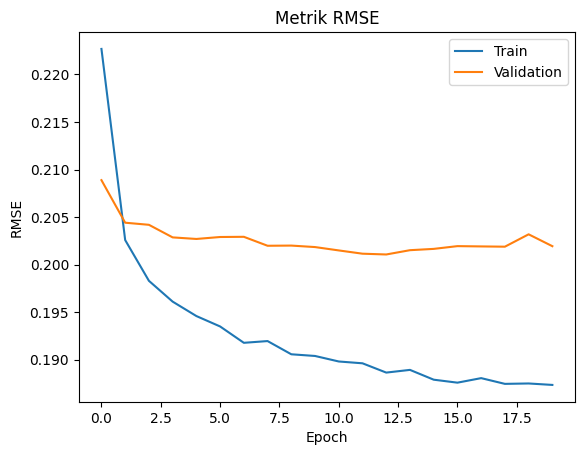

In [51]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Metrik RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Tahap diatas digunakan untuk menampilkan visualiasi metrik evaluasi dari pelatihan model sebelumnya. Dari hasil ini, dapat dilihat bahwa proses training model cukup baik, tidak mengalami overfitting, dan model konvergen.

#### Mendapatkan Rekomendasi Film Berdasarkan Rating Sebelumnya

In [52]:
movie_df = movies
df = pd.read_csv('ratings.csv')

user_id = df.userId.sample(1).iloc[0]
movie_rated_by_user = df[df.userId == user_id]

movie_not_rated = movie_df[~movie_df['movieId'].isin(movie_rated_by_user.movieId.values)]['movieId']
movie_not_rated = list(
    set(movie_not_rated)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movie_not_rated = [[movie_to_movie_encoded.get(x)] for x in movie_not_rated]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_rated), movie_not_rated)
)

Tahap diatas merupakan tahap untuk mengambil satu sampel pengguna secara acak yang nantinya akan dianalisis dan diberikan rekomendasi film berdasarkan riwayat rating yang pernah diberikan oleh pengguna. Selain mengambil satu pengguna, hal yang dilakukan pada tahap ini adalah membuat vaiabel film yang belum diberikan penilaian oleh pengguna. Hal ini diperlukan karena film yang akan direkomendasikan tentu idealnya adalah film yang belum pernah ditonton oleh pengguna. Jika film telah dirating oleh pengguna, artinya pengguna telah menonton film tersebut maka film-film yang sudah dirating akan dikecualikan dari rekomendasi.

In [55]:
rating = model.predict(user_movie_array).flatten()

top_ratings_indices = rating.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_rated[x][0]) for x in top_ratings_indices
]

print('Rekomendasi Film untuk Pengguna dengan ID: {}'.format(user_id))
print('\n5 Film dengan Rating Tertinggi oleh Pengguna')
print('----' * 8)

top_movie_user = (
    movie_rated_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ':', row.genres)

print('\nTop 10 Film Hasil Rekomendasi')
print('----' * 8)

recommended_movie = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title, ':', row.genres)

226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Rekomendasi Film untuk Pengguna dengan ID: 599

5 Film dengan Rating Tertinggi oleh Pengguna
--------------------------------
Rumble in the Bronx (Hont faan kui) (1995) : Action|Adventure|Comedy|Crime
2001: A Space Odyssey (1968) : Adventure|Drama|Sci-Fi
His Girl Friday (1940) : Comedy|Romance
Road Warrior, The (Mad Max 2) (1981) : Action|Adventure|Sci-Fi|Thriller
Lost in Translation (2003) : Comedy|Drama|Romance

Top 10 Film Hasil Rekomendasi
--------------------------------
Secrets & Lies (1996) : Drama
Once Upon a Time in the West (C'era una volta il West) (1968) : Action|Drama|Western
Ran (1985) : Drama|War
Bridge on the River Kwai, The (1957) : Adventure|Drama|War
Patton (1970) : Drama|War
Night on Earth (1991) : Comedy|Drama
Guess Who's Coming to Dinner (1967) : Drama
Trial, The (Procès, Le) (1962) : Drama
Adam's Rib (1949) : Comedy|Romance
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama


Tahap diatas adalah tahap untuk memperoleh 10 rekomendasi film untuk pengguna berdasarkan riwayat film yang dirating oleh pengguna. Tahapan diatas menampilkan id pengguna, 5 film dengan rating tertinggi dari pengguna, dan 10 rekomendasi film untuk pengguna. Hasil dari tahapan diatas adalah:
1. Pengguna yang terpilih secara acak adalah pengguna dengan id 599.
2. Film dengan rating tertinggi yang diberikan oleh pengguna berkisar pada genre Action, Adventure, Comedy, Crime, Drama, Sci-Fi, Romance, dan Thiller.
3. Hasil rekomendasi film yang diberikan untuk pengguna cukup selaras dengan film yang dirating tinggi oleh pengguna yaitu berkisar pada genre Drama, Comedy, Adventure, dan Crime.